In [ ]:
from google.colab import drive
drive.mount("/content/drive/",force_remount=True)

from zipfile import ZipFile
! cp '/content/drive/MyDrive/ML_Capstone/drive-download.zip' '/content'
from zipfile import ZipFile
zip = ZipFile('/content/drive-download.zip')
zip.extractall()

Mounted at /content/drive/


In [ ]:
# importing required packages
import os
import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import numpy as np
import cv2
import pickle as pkl
import matplotlib.pyplot as plt
from torchvision import models
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
import pandas as pd
import torchvision

# Dataset and Dataloaders

In [ ]:
# Set device to cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Lazy Loading

data
-train
  - X
    - 1
      - rgb
        - 0.png
        - 1.png
        - 2.png
      - depth.npy
      - field_id.pkl
    
    - 2

    - ...
  - Y
    - 1.npy
    - 2.npy

-test

In [ ]:
class LazyLoadDataset(Dataset):
  def __init__(self,path,train=True,transform=None):
    self.train = train
    self.transform = transform
    path = path + ("train/" if self.train else "test/")

    self.pathX = path + "X/"
    self.pathY = path + "Y/"

    self.data = os.listdir(self.pathX)

  def __getitem__(self,idx):
    f = self.data[idx]

    # X
    # read rgb images
    #img0 = cv2.imread(self.pathX + f + "/rgb/0.png")/255

    # read depth images
    depth = np.load(self.pathX + f + "/depth.npy")/1000
    depth = depth.transpose((1,2,0))
        
    if self.transform is not None:
      depth = self.transform(depth)

    # read field ID
    field_id = pkl.load(open(self.pathX + f + "/field_id.pkl","rb"))

    if self.train==True:
      # Y 
      Y = np.load(self.pathY + f + ".npy")*1000
      return (depth.float().type(torch.float32),field_id),torch.from_numpy(Y).float().type(torch.float32)

    else: # if test, there is no Y
      return depth.float().type(torch.float32),field_id

  def __len__(self):
    return len(self.data)


# Normalization: Compute Mean and Std



In [ ]:
train_dataset_raw = LazyLoadDataset("/content/",train=True,transform=ToTensor()) 
means=[]
stds=[]
for i in range(3396):
  (depth_i, id_i),Y_i=train_dataset_raw[i]
  means.append([torch.mean(depth_i[0]).item(),torch.mean(depth_i[1]).item(),torch.mean(depth_i[2]).item()])
  stds.append([torch.std(depth_i[0]).item(),torch.std(depth_i[1]).item(),torch.std(depth_i[2]).item()])

In [ ]:
depth_i.shape

torch.Size([3, 224, 224])

In [ ]:
means

In [ ]:
norm_mean=np.mean(means,axis =0)
norm_mean = list(norm_mean)
norm_mean

[0.6557701463834136, 0.8711379854923423, 1.2105857684804637]

In [ ]:
norm_std=np.mean(stds,axis=0)
norm_std = list(norm_std)
norm_std

[0.40322135255460323, 0.6190313919062328, 1.0969438298185246]

# Train Dataset & Train loader

In [ ]:
#transform=transforms.Compose([transforms.ToTensor()])
train_dataset = LazyLoadDataset("/content/",transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(norm_mean, norm_std),])) 

In [ ]:
train_dataset[0]

((tensor([[[ 0.7917,  0.7892,  0.7867,  ...,  0.7942,  0.7942,  0.7967],
           [ 0.7917,  0.7867,  0.7867,  ...,  0.7917,  0.7942,  0.7942],
           [ 0.7917,  0.7892,  0.7867,  ...,  0.7917,  0.7917,  0.7917],
           ...,
           [ 0.7272,  0.7371,  0.7471,  ...,  0.7818,  0.7843,  0.7843],
           [ 0.7198,  0.7272,  0.7396,  ...,  0.7818,  0.7818,  0.7818],
           [ 0.7148,  0.7223,  0.7371,  ...,  0.7793,  0.7793,  0.7793]],
  
          [[-1.4073, -1.4073, -1.4073,  ..., -1.4073, -1.4073, -1.4073],
           [-1.4073, -1.4073, -1.4073,  ..., -1.4073, -1.4073, -1.4073],
           [-1.4073, -1.4073, -1.4073,  ..., -1.4073, -1.4073, -1.4073],
           ...,
           [-0.2765, -0.2781,  0.1048,  ..., -0.0115, -0.0131, -0.0148],
           [-0.2668,  0.1048,  0.1048,  ..., -0.0148, -0.0180, -0.0212],
           [-0.2635,  0.1048,  0.1048,  ..., -0.0196, -0.0228, -0.0261]],
  
          [[ 1.0925,  1.0788,  1.0560,  ...,  2.4426,  2.4599,  2.4691],
           

In [ ]:
(depth0, field_id), Y = train_dataset[0]

In [ ]:
batch_size_train = 4
train_loader=DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)

torch.Size([4, 3, 224, 224])


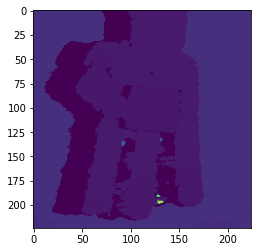

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
  #print(data) #plot the channel 3 of img0 in one batch
  print(data[0].shape)
  plt.imshow(data[0][0][0])
  #plt.show()
  #plt.imshow(data[0])
  break

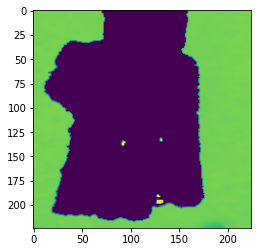

In [ ]:
before_aug = data[0][0]

after_aug = F.adjust_sharpness(before_aug,sharpness_factor = 0.5)

plt.imshow(after_aug[0])

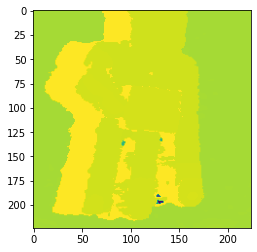

In [ ]:
after_aug = F.invert(before_aug)
plt.imshow(after_aug[0])

Inverting looks better than adjusting sharpness.

# Test Dataset & Test loader

In [ ]:
test_dataset = LazyLoadDataset("/content/",train=False,transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(norm_mean, norm_std),
                   ])) #,transform=transform

batch_size_test = 2
test_loader=DataLoader(test_dataset,batch_size=batch_size_test,shuffle=True)

# Model

In [ ]:
class Res(nn.Module):
    def __init__(self, input_channels,output_size):
        super(Res, self).__init__()
        
        # We use Sequential for simplicity
        self.stack = nn.Sequential(models.resnet50(pretrained=True),
                                   nn.Linear(1000, output_size))
                                 
    def forward(self, x):
        x = self.stack(x)
        return x

In [ ]:
# Model input/output settings
input_channels = 3 # number of input channels
output_size=12

In [ ]:
def train(epoch, model, optimizer,loader=train_loader):
    """
    Train the model for one epoch

    Args:
        epoch (int): current epoch
        model (nn.Module): model to train
        optimizer (torch.optim): optimizer to use
        loader: val/train loader
    """
    model.train()
    for batch_idx,((data, id),target) in enumerate(loader):
        # send to device
        data, target = data.to(device), target.to(device)
        data = data.view(len(id),3,224, 224)

        # consider passing different data augmentation in training
        data = F.invert(data)
        #data = F.adjust_sharpness(data,sharpness_factor = 5)
        # data = F.adjust_hue(data,hue_factor = 0.9)
        # data = F.adjust_saturation(data,saturation_factor = 0.5)

        # make sure we erase all the gradients before computing new ones
        optimizer.zero_grad() 
        
        # forward propagation
        output = model(data)

        #RMSE loss
        loss = torch.sqrt(nn.functional.mse_loss(output,target))
        
        # backward propagation
        loss.backward()
        optimizer.step()
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss))
            

In [ ]:
def test(model):
    """
    Test the model

    Args:
        model (nn.Module): model to test
      
    """
    model.eval()
    ids = []
    preds = []
    with torch.no_grad():
      for batch_idx,(data, id) in enumerate(test_loader):
        # send to device
        data = data.to(device)          
        pred = model(data)
        for i in range(len(id)):
          ids.append(id[i])
          preds.append(np.array(pred[i].cpu()/1000,dtype="float64"))

    return ids, preds  
    

In [ ]:
def get_n_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Cross-Validation & Grid-Search for determining hyperparameters

What should hyperparameters in the models be? We could perform grid-search on the whole train dataset and pick the best-performing hyerparameters. But to avoid over-fitting on the train dataset, we split the whole train dataset into 9:1.
*   cross_val_train_set (90% of train dataset)
*   cross_val_test_set (10% of train dataset)

We train our model on the cross_val_train_set and test our model on cross_val_test_set. We pick the best-performing hyperparameters on the cross_val_test_set.

After all these steps, we train our model using the picked hyperparameters on the whole train dataset. 

In [ ]:
cross_val_train_set, cross_val_test_set = train_test_split(train_dataset, test_size=0.1)

In [ ]:
# Sanity Check
len(cross_val_train_set) == int(len(train_dataset)*0.9)
len(cross_val_train_set)

3056

In [ ]:
batch_size_cross_val_train = 4
batch_size_cross_val_test = len(cross_val_test_set) # = 340
len(cross_val_test_set)

340

In [ ]:
cross_val_train_loader=DataLoader(cross_val_train_set,batch_size=batch_size_cross_val_train,shuffle=True)
cross_val_test_loader=DataLoader(cross_val_test_set,batch_size=batch_size_cross_val_test,shuffle=True)

In [ ]:
len(cross_val_test_loader)

1

In [ ]:
def cross_val(model):
    """
    Test the model

    Args:
        model (nn.Module): model to test
      
    """
    model.eval()
    # We can just edit on the code for train(). We should delete the bakward propagation part and optimizer part.

    with torch.no_grad():
      for batch_idx,((data, id),target) in enumerate(cross_val_test_loader):
          # send to device
          if batch_idx==0:
            data, target = data.to(device), target.to(device)
            
            # forward propagation
            output = model(data)

            #RMSE loss
            loss = torch.sqrt(nn.functional.mse_loss(output,target))
            return loss.item()

In [ ]:
def SGD_hyper_tuning(lr_list,momentum_list):  
  for j in momentum_list:
    for i in lr_list:
      model_res = Res(input_channels, output_size) # create Res model
      model_res.to(device)
      print("lr=",i,"momentum=",j)
      train(epoch=0, model=model_res, optimizer=torch.optim.SGD(model_res.parameters(), lr=i,momentum=j),loader=cross_val_train_loader)
      print("Validation Performance:",cross_val(model_res))

In [ ]:
lr_list = [1e-5,1e-4,1e-3,1e-2,1e-1]
momentum_list = [0.99,0.97,0.95,0.93,0.91]
SGD_hyper_tuning(lr_list,momentum_list)

lr= 1e-05 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 69.571106
Train Epoch: 0 [800/3056 (26%)]	Loss: 60.399475
Train Epoch: 0 [1600/3056 (52%)]	Loss: 33.046825
Train Epoch: 0 [2400/3056 (79%)]	Loss: 20.199224
Validation Performance: 23.439308166503906
lr= 0.0001 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 66.736038
Train Epoch: 0 [800/3056 (26%)]	Loss: 18.452808
Train Epoch: 0 [1600/3056 (52%)]	Loss: 18.100435
Train Epoch: 0 [2400/3056 (79%)]	Loss: 9.324109
Validation Performance: 29.560087203979492
lr= 0.001 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 65.231468
Train Epoch: 0 [800/3056 (26%)]	Loss: 15.215971
Train Epoch: 0 [1600/3056 (52%)]	Loss: 20.695974
Train Epoch: 0 [2400/3056 (79%)]	Loss: 13.972851
Validation Performance: 32.399906158447266
lr= 0.01 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 69.210632
Train Epoch: 0 [800/3056 (26%)]	Loss: 17.725046
Train Epoch: 0 [1600/3056 (52%)]	Loss: 17.664530
Train Epoch: 0 [2400/3056 (79%)]	Loss: 15.021599
Validati

Worse Performance than no augmentation. 